# Cybersecurity Threat ML Project

## Introduction

Here is the link of our GitHub repository : https://github.com/ML-Cyber-Project/AtDBackend

The aim of our cybersecurity project is to treat and analyse data from a wireshark recording so that we can identify threats. We tried to develop a model which can predict if a record contains a DoS attack.

We organized our team with a lead developper who assigned tasks and code to others. There was also an infrastructure leader. All the brainstorms were done together. 

Technically we divided the project into different files for the data cleaning, the data preparation and the predictions. We also designed our infrastructure with a dockerfile and a docker compose stack. When deployed in production the server runs fastAPI from `app.py`. We calculated some models' metrics that we saved on MlFlow.

NB: Please note that you will NOT be able to run this notebook as it is and the code here is sample code. The actual code is in the repository.

## Code

### `Download.py`

Firstly we imported kaggle. We defined a function to download the data from kaggle. We printed the path to the dataset during the execution.

In [ ]:
import kagglehub

def download_dataset() -> str:
    # Download latest version and return path of downloaded files
    return kagglehub.dataset_download("chethuhn/network-intrusion-dataset")


if __name__ == "__main__":
    print(f"Path to dataset: {download_dataset()}")

### `Clean.py`

Firstly we did some imports. We ensured that if the user didn't have the libraries he received a message saying that he must install it.

In [ ]:
import os
from download import download_dataset

try:
    import pandas as pd
except ImportError:
    print("You need to install pandas")
    exit()

try:
    import numpy as np
except ImportError:
    print("You need to install numpy")
    exit()

Fristly, we had to load and clean the data. We start by concatenating all the csv files in the dataframe called "global_df". We then perform a cleanup on the columns names as they contained spaces using the strip() function. Then we dropped the features that had a high percentage of similarity (95% was the optimal value after thorough testing). We also dropped duplicated lines if any and all lines whose label is not "BENIGN" neither "DoS".

In [ ]:
COLUMN_SIMILARITY_THRESHOLD = 95

def get_percentage_columns_similarity(df):
    return (1 - (df.nunique() / len(df))) * 100

def load_and_clean_data(data_path=download_dataset()):
    global_df = pd.DataFrame()
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(root, file))
                global_df = pd.concat([global_df, df], ignore_index=True)

    global_df.columns = global_df.columns.str.strip()

    # Drop columns according to similarity threshold
    columns_to_drop = get_percentage_columns_similarity(global_df)
    columns_to_drop = columns_to_drop[columns_to_drop > COLUMN_SIMILARITY_THRESHOLD].index
    # Don't drop the label column
    columns_to_drop = columns_to_drop.drop('Label')
    global_df = global_df.drop(columns=columns_to_drop)
    global_df = global_df.replace([float('-inf'), float('inf')], float('nan')).dropna()
    # drop duplicates
    global_df = global_df.drop_duplicates()
    # Drop all lines where the label is not BENIGN or does not contains "DoS"
    global_df = global_df[global_df['Label'].str.contains('DoS') | global_df['Label'].str.contains('BENIGN')]

    return global_df

To avoid having to clean the data everytim, we had to save the features and the labels using the following simple function that converts the labels from strings to binary values (0 for "BENIGN" and 1 for "DoS").

In [ ]:
def save_features_and_labels(global_df, features_path='data/features.csv', labels_path='data/labels.csv'):
    # Separate label column from features
    global_df['Label'] = np.where(global_df['Label'].isin(['BENIGN']), 0, 1)
    print("Labels count : ", global_df['Label'].value_counts())
    labels = global_df['Label']
    features = global_df.drop(columns=['Label'])

    # Create features_path and labels_path's directory if it doesn't exist
    if not os.path.exists(os.path.dirname(features_path)):
        os.makedirs(os.path.dirname(features_path))
    if not os.path.exists(os.path.dirname(labels_path)):
        os.makedirs(os.path.dirname(labels_path))

    # Save to csv
    features.to_csv(features_path, index=False)
    labels.to_csv(labels_path, index=False)

    print(f"Features and labels saved to {features_path} and {labels_path}")

### `Preparation.py`

We imported multiple libraries : Pandas allows dataframes manipulation, seaborn and matplotlib allow data visualization, numpy allows math calculations and array manipulation, and RandomUnderSampler allows undersampling.

We loaded the features and the labels that we cleaned in the previous step.

In [ ]:
def load_data(features_path, labels_path):
    features = pd.read_csv(os.path.abspath(features_path))
    labels = pd.read_csv(os.path.abspath(labels_path))
    return features, labels

Then we wanted to do and save a correlation matrix. First, we merged the features with the labels to get a "global" dataframe. Then, we calculated the correlation matrix. We plotted it, making sure that the lowest values were in blue and the highest in red. Finally, we saved the image in a file.

In [ ]:
def save_correlation_matrix(df, labels, filename):
    features_with_labels = df.copy()
    features_with_labels['Label'] = labels
    corr = features_with_labels.corr()
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.savefig(filename)
    print(f"Correlation matrix saved to {filename}")

Our data was unbalanced so we decided to do some undersampling. We used the RandomUnderSampler() function which undersample the majority class. We applied the undersampling on our data and we saved it.

In [ ]:
def resample_data(features, labels):
    rus = RandomUnderSampler(random_state=17, sampling_strategy='majority')
    features_resampled, labels_resampled = rus.fit_resample(features, labels)
    return features_resampled, labels_resampled

After plotting and analyzing it, we decided that we had to drop the most correlated features. For that we defined a threshold. We created the upper triangle of the correlation matrix (as the rest of the data was "duplicated"), we selected the colums with the correlations above the threshold and we dropped them. 

In [ ]:
def clean_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    # Create the upper triangle of the correlation matrix (no need to keep the lower triangle and diagonal)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Select columns with correlations above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

Here are the 3 correlation matrix we obtained : 

After cleaning : 

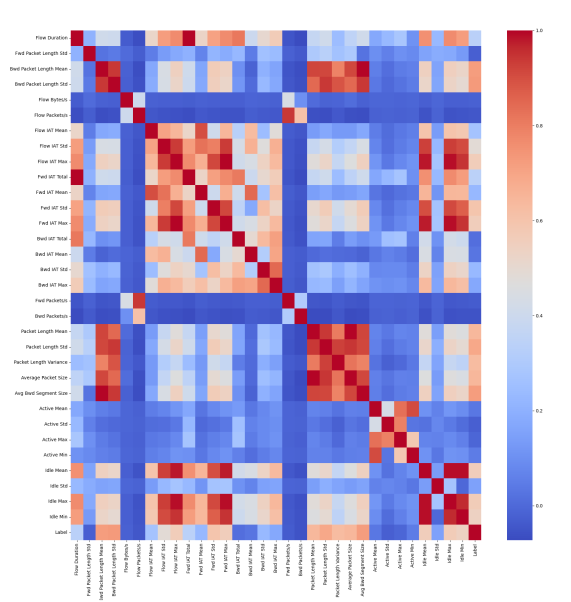

After resampling : 

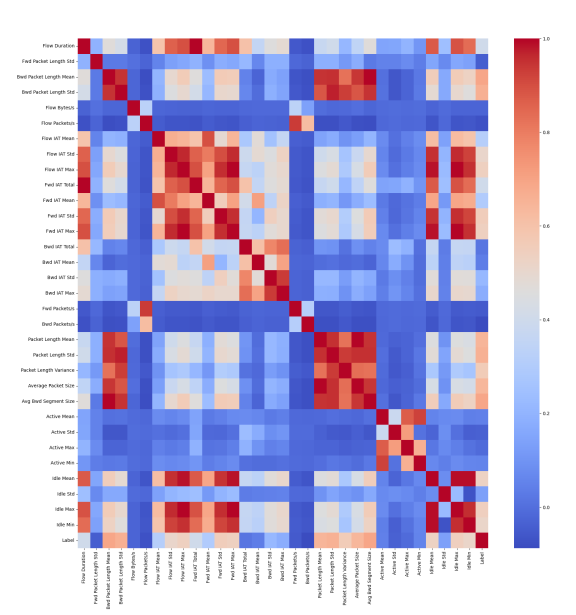

After preparation (dropping the highly correlated features) : 

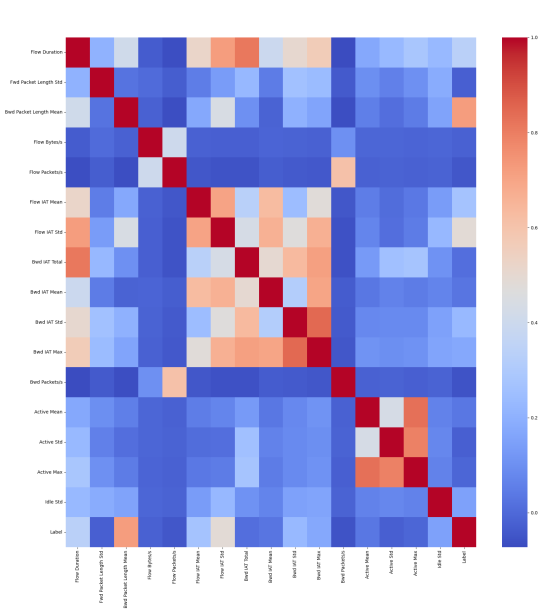 

We can observe that the red squares were dropped which means we obtained less correlated features thanks to the cleaning, the resampling and the preparation.

### `Prediction.py`

In this file we performed some training and testing of different models on data. 

We used python library sklearn.

The models we tested are : 
- logistic regression
- random forest
- k-nn
- decision tree

We calculated some metrics for each model to compare them and choose the best one : 
- f1 score
- precision score
- recall score
- roc auc score

To simplify the step of choosing the best model, we used MLFlow, a tool that allows us to save the metrics of each model and compare them in a fancy interface.
We had the opportunity to create a hosted MLFlow server to be able to share the results with the team without having to send the files.

In [ ]:
mlflow.set_tracking_uri("https://mlflow.docsystem.xyz")

We created 2 dataframes from the csv files of features and labels cleaned.

In [ ]:
features = pd.read_csv(os.path.abspath('data/features_cleaned.csv'))
labels = pd.read_csv(os.path.abspath('data/labels_cleaned.csv'))

We splitted the data for training (70%) and testing (30%).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=25)

We reset the indexes of both train and test data in order to ensure some consistency.

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

We defined a dictionary for the different models to be able to loop over them.

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

And we also defined a dictionary for the different models' hyperparameters, to be able to do tuning on them.

In [ ]:
param_distributions = {
    "Logistic Regression": {
        'C': np.logspace(-10, 10, 100),
    },
    "Random Forest": {
        'min_samples_split': np.arange(2, 21),
        'max_depth': np.arange(1, 21)
    },
    "KNN": {
        'n_neighbors': np.arange(1, 21),
        'p': np.arange(1, 6)
    },
    "Decision Tree": {
        'max_depth': np.arange(1, 21),
        'min_samples_split': np.arange(2, 21),
    }
}

We initialized some variables to store the best model, the best score and the best parameters.

In [ ]:
best_model = None
best_score = float('-inf')
best_params = None

Then we made a loop for training and testing each model. We tried to find the best hyperparameters. Then we save the actual model and its parameter distributions.
We also had to perform some scaling (except for the random foret model) with StandardScaler() and fit_transform() functions because the models we used were sensitive to the scale of the data.

In [ ]:
for name in models.keys():
    print("Tuning hyperparameters for model", name)
    
    model = models[name]
    param_dist = param_distributions[name]
    
    if name != "Random Forest":
        # Scale data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

Still in the loop, we defined a function calculating the f1 score that will be used to determine the best hyperparameters combination.

In [ ]:
def scoringfunc(estimator, X, y):
    return f1_score(y, estimator.predict(X))

We used the RandomizedSeachCV() function to find the best hyperparameters. The RandomizedSearchCV() function is a cross-validation method that, instead of trying all the possible combinations of hyperparameters, tries a fixed number of them. This is useful when the number of hyperparameters is very high and the computation time is too long.

In [ ]:
randomized_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_dist,
    n_iter=NUM_TRIALS,
    scoring=scoringfunc,
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=3
)

randomized_search.fit(X_train_scaled, y_train.values.ravel())

best = randomized_search.best_params_
model.set_params(**best)
model.fit(X_train_scaled, y_train.values.ravel())

We created a signature for the MLFlow server, it is useful to define the expected format for the inputs and outputs of the model.
After that, we started a MLFlow run for the model. We logged the parameters, some metrics and the model itself.

In [ ]:
signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))

with mlflow.start_run(run_name=name) as run:
    mlflow.log_params(best)
    mlflow.sklearn.log_model(model, "model", signature=signature)
    mlflow.log_metric("F1_Score", f1_test)
    mlflow.log_metric("Accuracy", model.score(X_test_scaled, y_test))
    mlflow.log_metric("Precision", precision_score(y_test, model.predict(X_test_scaled)))
    mlflow.log_metric("Recall", recall_score(y_test, model.predict(X_test_scaled)))
    mlflow.log_metric("AUC", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))
    
    if f1_test > best_score:
        best_score = f1_test
        best_model = model
        best_params = best

Then we saved the best parameters and scores in a MlFlow experiment.

In [ ]:
mlflow.set_experiment("BestModelParams")
name = best_model.__class__.__name__
with mlflow.start_run(run_name=name) as run:
    mlflow.log_params(best_params)
    mlflow.log_metric("f1", best_score)

### `test.py`

We used this file for testing our random forest model. We obtained a confusion matrix : 

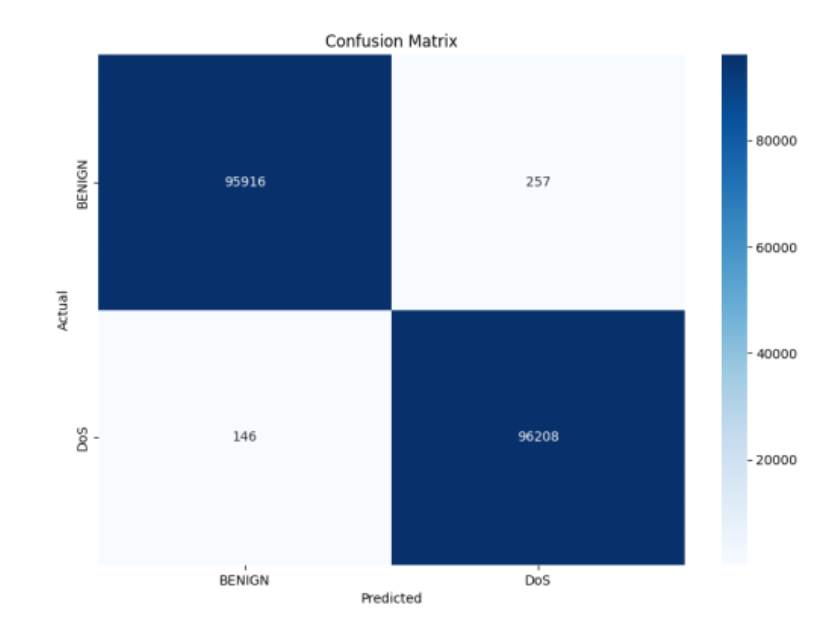

Here we can see that :

TP = 96208, which corresponds to the number of actual attacks predicted.

TN = 95916

FP = 257

FN = 146

### `app.py`

We constructed an API thanks to FastAPI from fastapi library and BaseModel from pydantic library.

We configured the uri of the tracker server for MlFlow.

In [ ]:
mlflow.set_tracking_uri("https://mlflow.docsystem.xyz")

We loaded the model we choose to deploy (random forest model).

In [ ]:
model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/latest")

We set the column names mapping.

In [ ]:
COLUMN_MAPPINGS = {
    "flow_duration": "Flow Duration",
    "fwd_packet_length_std": "Fwd Packet Length Std",
    "bwd_packet_length_mean": "Bwd Packet Length Mean",
    "flow_bytes_s": "Flow Bytes/s",
    "flow_packets_s": "Flow Packets/s",
    "flow_iat_mean": "Flow IAT Mean",
    "flow_iat_std": "Flow IAT Std",
    "bwd_iat_total": "Bwd IAT Total",
    "bwd_iat_mean": "Bwd IAT Mean",
    "bwd_iat_std": "Bwd IAT Std",
    "bwd_iat_max": "Bwd IAT Max",
    "bwd_packets_s": "Bwd Packets/s",
    "active_mean": "Active Mean",
    "active_std": "Active Std",
    "active_max": "Active Max",
    "idle_std": "Idle Std"
}

We created an instance of FastAPI app.

In [ ]:
app = FastAPI()

We defined a function whose aim is to transform a dictionary into a dataframe, and another function whose aim is to scale the dataframe.

In [ ]:
def to_df(self):
    df = pd.DataFrame([self.dict()])
    # Change column labels
    for column in df.columns:
        df = df.rename(columns={column: COLUMN_MAPPINGS[column]})
    return df

def scale_df(self):
    scaler = StandardScaler()
    return scaler.transform(self.to_df())

Finally we made a FastAPI route that returns the predictions of models from the input.

In [ ]:
@app.post('/reports/')
async def create_report(report: Report):
    # Make predictions
    predictions = model.predict(report.scale_df())
    print(predictions)
    predictions = [LABELS_NUM[prediction] for prediction in predictions.tolist()]
    return {"predictions": predictions}

## Infrastructure

### Docker

We used docker as a container for our application. Technically, we made a dockerfile that creates a Docker image.

Here are the steps we followed : 

- We used specified the environment : python 3.09
- We defined the directory app in which we copied the content of the current directory. 
- We install some python dependencies. 
- We specified the port on which the app listens.
- We specified the default command.

In [ ]:
FROM python:3.9

WORKDIR /app

COPY . /app

RUN pip install --upgrade pip
RUN pip install -r requirements.txt

EXPOSE 8000

CMD ["/bin/sh", "-c", "/app/entrypoint.sh"]

We used docker compose tool in order to setup the container and the network.

In [ ]:
services:
  backend:
    image: ghcr.io/ml-cyber-project/atdbackend:main
    networks:
      - reverseproxy
    restart: always
    labels:
      traefik.enable: true
      traefik.http.routers.atdbackend.rule: Host(`atdbackend.docsystem.xyz`)

networks:
  reverseproxy:
    external: true

### MlFlow

We used MlFLow for tracking the experiments and records the models' metrics, hyperparameters and other informations.

For Random Forest we obtained those results :

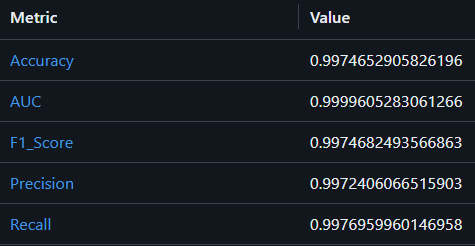

For Logistic regression we obtained those results :

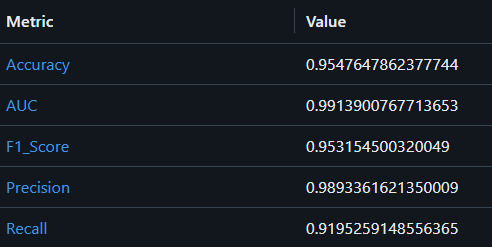

For k-nn we obtained those results :

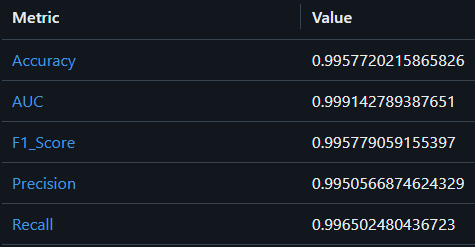

For Decision tree we obtained those results :

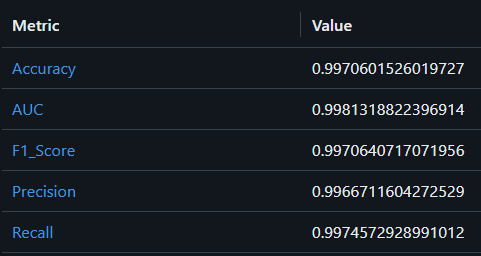

We chose the model with the best metrics to deploy it in production.
In our case, the **Random Forest** model was the best one.

### CI/CD

## Conclusion

This project allowed us to apply all the course materials. We loaded a dataset that we cleaned and prepared. We performed some training and some testing. We calculated metrics and hyperparameters to find the best model. We learned to use MlFlow in order to handle our experiments. We deployed our application on docker that we also learned to use.

The biggest difficulty was to choose the best model which took us some time. We fixed it with the hyperparameters' tuning which allowed us to find the best parameters. We also faced the issue of unbalanced data that we fixed with some undersampling on the majority class.